# Cross-correlation of spectral envelope and HFB during noisy fragments in speech isolated and mixed tracks

In [4]:
import matplotlib as mpl
mpl.use('TkAgg')
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests as mult
from utils import load_noisy_fragment_times, cross_correlate, zscore

%matplotlib inline

In [5]:
noisy = load_noisy_fragment_times('../data/')
isolated = np.load('../data/audio_envelope_100Hz_clean.npy')
mixed = np.load('../data/audio_envelope_100Hz.npy')

In [6]:
subj = 's1'
x    = np.load('../data/' + subj + '_HD_100Hz_hfb.npy')
pm = np.load('../results/ttest_ecog_speech_nonspeech_'+subj+'_pmask.npz')['pmask_bonf'] # pmask from the first ttest
grid = np.load('../data/' + subj + '_HD_grid.npy')
n = x.shape[-1]

In [7]:
# cross-correlation
r_iso, r_mix = [], []
for spe_frag in noisy:
    r_iso.append([])
    r_mix.append([])
    for i in range(x.shape[-1]):
        r_iso[-1].append(cross_correlate(x[spe_frag[0]:spe_frag[1], i], 
                                         isolated[spe_frag[0]:spe_frag[1]], type='spearman'))
        r_mix[-1].append(cross_correlate(x[spe_frag[0]:spe_frag[1], i], 
                                         mixed[spe_frag[0]:spe_frag[1]], type='spearman'))

r_iso, r_mix = np.array(r_iso), np.array(r_mix)

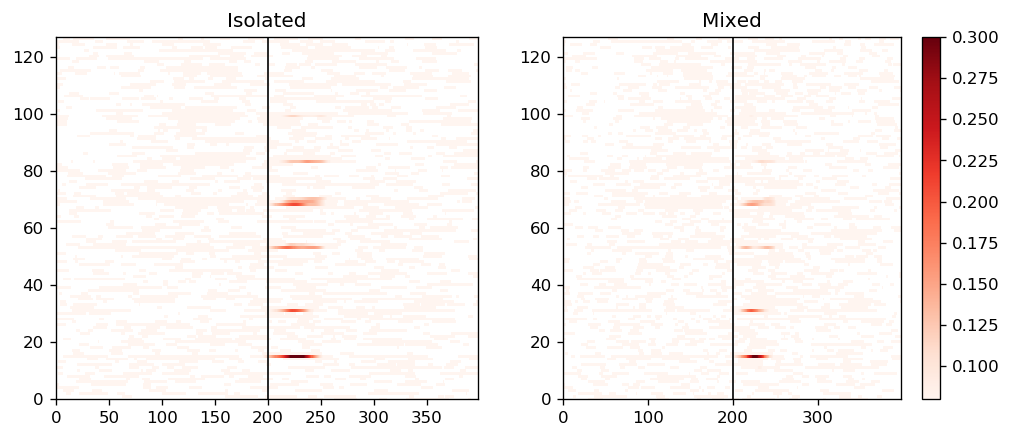

In [9]:
# cross-correlation profiles
cmap = mpl.cm.get_cmap('Reds')
cmap.set_bad((1, 1, 1))
d = np.mean(r_iso, 0)[:, 200:-200].copy()
d[np.abs(d) < .015] = np.nan
plt.figure(figsize=(10, 4), dpi=120)
plt.subplot(121)
plt.imshow(d, aspect='auto', vmin=.08, vmax=.3, cmap=cmap)
plt.plot([200, 200], [0, x.shape[-1]], 'k', linewidth=1)
plt.ylim(0, x.shape[-1]-1)
plt.title('Isolated')

d = np.mean(r_mix, 0)[:, 200:-200].copy()
d[np.abs(d) < .015] = np.nan
plt.subplot(122)
plt.imshow(d, aspect='auto', vmin=.08, vmax=.3, cmap=cmap)
plt.plot([200, 200], [0, x.shape[-1]], 'k', linewidth=1)
plt.ylim(0, x.shape[-1]-1)
plt.title('Mixed')
plt.colorbar()
plt.show()

In [10]:
# take max correlation within [-100:500] ms per fragment
r_iso_m = np.max(r_iso[:, :,390:-349], 2)
r_mix_m = np.max(r_mix[:, :,390:-349], 2)

In [11]:
# fisher transform
r_iso_mf = np.arctanh(r_iso_m)
r_mix_mf = np.arctanh(r_mix_m)

In [21]:
# t-test on spe vs non
ts, ps = [], []
for i, j in zip(r_iso_mf.T, r_mix_mf.T):
    t, p = ttest_rel(i, j)
    ts.append(t)
    ps.append(p)
ts, ps = np.array(ts), np.array(ps)
ts_masked = ts.copy()

In [29]:
# significance
thresh_05 = 5e-2/pm.shape[0]
thresh_01 = 1e-2/pm.shape[0]
ts_masked[ps >= thresh_05] = 0
ts_masked[np.setdiff1d(range(n), pm)] = 0

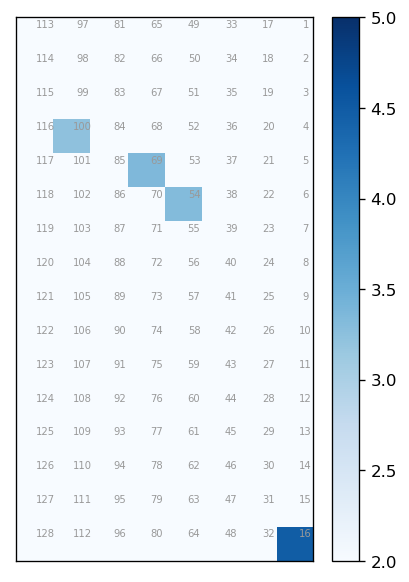

In [31]:
# plot for s1
plt.figure(figsize=(4, 6), dpi=120)
cmap = plt.get_cmap('Blues')
cmap.set_bad((.7, .7, .7))
plt.imshow(ts_masked[grid], aspect='auto', cmap = cmap, vmin = 2, vmax = 5, extent=[0, grid.shape[-1], 0, grid.shape[0]])
for (i, j), k in np.ndenumerate(np.flipud(grid)):
    plt.gca().text(j+.8, i+.8, k+1, ha='center', va='center', color=(.6, .6, .6), fontsize=6)
plt.xticks([])
plt.yticks([])
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.colorbar()
plt.show()

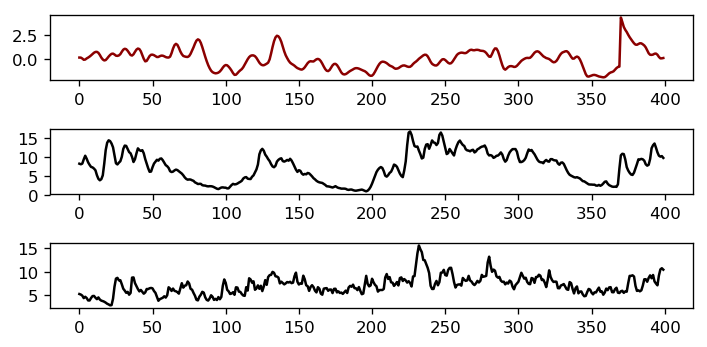

In [32]:
# plot example time courses
el = 83
frag = noisy[17]
plt.figure(figsize=(6, 3), dpi=120)
plt.subplot(311)
plt.plot(np.roll(zscore(x[frag[0]:frag[1], el]), -30), 'darkred')

plt.subplot(312)
plt.plot(isolated[frag[0]:frag[1]], 'k')

plt.subplot(313)
plt.plot(mixed[frag[0]:frag[1]], 'k')
plt.tight_layout()
plt.show()